AUC Score (P(Churn)): 0.7187
Model, scaler, and feature list saved successfully.


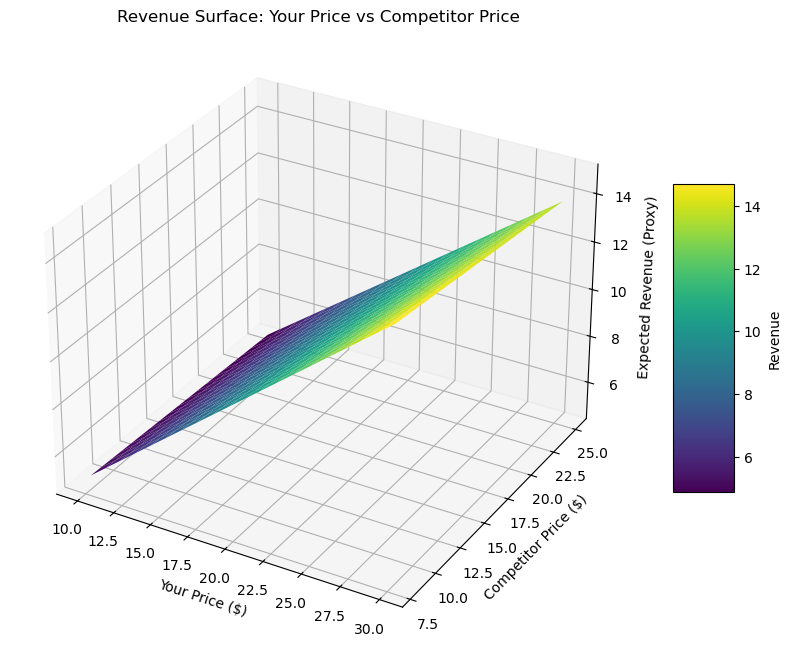

In [17]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import joblib

# -----------------------------
# 1️⃣ Load Data
# -----------------------------
try:
    data = pd.read_csv("C:/Users/Musinguzi/Documents/netflix_pricing_model_results.csv")
except FileNotFoundError:
    print("WARNING: Could not load file. Creating dummy data.")
    np.random.seed(42)
    data = pd.DataFrame({
        'Churn': np.random.randint(0, 2, 100),
        'ValueSegment': np.random.choice(['high', 'medium', 'low', 'very high', 'very low'], 100),
        'Engagementscore': np.random.rand(100) * 100,
        'Subscriptiontype': np.random.choice(['Basic', 'Standard', 'Premium'], 100),
        'Paymentmethod': np.random.choice(['CreditCard', 'Paypal'], 100),
        'Paymentplan': np.random.choice(['Monthly', 'Quarterly'], 100),
        'Age': np.random.randint(18, 60, 100),
        'Numsubscriptionpauses': np.random.randint(0, 3, 100),
        'Customerserviceinquiries': np.random.randint(0, 5, 100),
        'Watchhoursperweek': np.random.rand(100) * 20,
        'Averagesessionlength': np.random.rand(100) * 60,
        'Songskiprate': np.random.rand(100) * 0.5,
        'Weeklysongsplayed': np.random.randint(10, 100, 100),
        'Weeklyuniquesongs': np.random.randint(5, 50, 100),
        'Numfavoriteartists': np.random.randint(0, 20, 100),
        'Numplatformfriends': np.random.randint(0, 50, 100),
        'Numplaylistscreated': np.random.randint(0, 10, 100),
        'Numsharedplaylists': np.random.randint(0, 5, 100),
        'Notificationsclicked': np.random.randint(0, 10, 100),
    })

# -----------------------------
# 2️⃣ Simulate Additional Columns
# -----------------------------
price_map = {'high': 22, 'medium': 15, 'low': 10, 'very high': 25, 'very low': 8}
data['price'] = data['ValueSegment'].map(price_map).fillna(15)
data['CompetitorPrice'] = data['price'] * np.random.uniform(0.8, 1.2, size=len(data))
data['PreferenceScore'] = data['Engagementscore'] * np.random.uniform(0.9, 1.1, size=len(data))

# -----------------------------
# 3️⃣ One-Hot Encoding
# -----------------------------
categorical_cols = ['Subscriptiontype', 'Paymentmethod', 'ValueSegment', 'Paymentplan']
data = pd.get_dummies(data, columns=categorical_cols, drop_first=True)

# -----------------------------
# 4️⃣ Define Features & Target
# -----------------------------
target = 'Churn'
y = data[target]

numeric_features = [
    'Age', 'Numsubscriptionpauses', 'Customerserviceinquiries',
    'Watchhoursperweek', 'Averagesessionlength', 'Songskiprate',
    'Weeklysongsplayed', 'Weeklyuniquesongs', 'Numfavoriteartists',
    'Numplatformfriends', 'Numplaylistscreated', 'Numsharedplaylists',
    'Notificationsclicked', 'Engagementscore', 'price', 'CompetitorPrice', 'PreferenceScore'
]

dummy_features = [col for col in data.columns if any(c in col for c in ['Subscriptiontype_', 'Paymentmethod_', 'ValueSegment_'])]

features = numeric_features + dummy_features

X = data[features]
y = data[target]

# Ensure only numeric columns (for scaling)
X = X.select_dtypes(include=np.number)

# -----------------------------
# 5️⃣ Split and Scale
# -----------------------------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# -----------------------------
# 6️⃣ Train Model
# -----------------------------
model = LogisticRegression(solver='liblinear', random_state=42)
model.fit(X_train_scaled, y_train)

# Evaluation
y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
auc = roc_auc_score(y_test, y_pred_proba)
print(f"AUC Score (P(Churn)): {auc:.4f}")

# -----------------------------
# 7️⃣ Save Model, Scaler, and Features List
# -----------------------------
joblib.dump(model, 'revenue_optimization_model.pkl')
joblib.dump(scaler, 'scaler_rev_opt.pkl')
joblib.dump(X_train.columns.tolist(), 'features_list.pkl')  # ✅ NEW: save feature list

print("Model, scaler, and feature list saved successfully.")

# -----------------------------
# 8️⃣ DEMAND/REVENUE ANALYSIS (3D Plot)
# -----------------------------
def predict_retention_proba(input_df, model, scaler, X_cols):
    """Predicts P(Retention) = 1 - P(Churn)"""
    input_df_reindexed = input_df.reindex(columns=X_cols, fill_value=0)
    input_scaled = scaler.transform(input_df_reindexed)
    p_churn = model.predict_proba(input_scaled)[:, 1]
    return 1 - p_churn

mean_values = X_train.mean().to_dict()
base_input_df = pd.DataFrame([mean_values])

price_range = np.linspace(10, 30, 20)
comp_price_range = np.linspace(8, 25, 20)
Price_Grid, CompPrice_Grid = np.meshgrid(price_range, comp_price_range)
Revenue_Grid = np.zeros_like(Price_Grid)

for i in range(Price_Grid.shape[0]):
    for j in range(Price_Grid.shape[1]):
        current_price = Price_Grid[i, j]
        current_comp_price = CompPrice_Grid[i, j]

        test_input = base_input_df.copy()
        test_input['price'] = current_price
        test_input['CompetitorPrice'] = current_comp_price
        test_input['PreferenceScore'] = mean_values['PreferenceScore']

        # Ensure all other features are set to their mean
        for col in X_train.columns:
            if col not in ['price', 'CompetitorPrice', 'PreferenceScore']:
                test_input[col] = mean_values.get(col, 0)

        demand = predict_retention_proba(test_input, model, scaler, X_train.columns)[0]
        Revenue_Grid[i, j] = current_price * demand

# Plotting
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(Price_Grid, CompPrice_Grid, Revenue_Grid,
                       cmap='viridis', edgecolor='none')
ax.set_xlabel('Your Price ($)')
ax.set_ylabel('Competitor Price ($)')
ax.set_zlabel('Expected Revenue (Proxy)')
ax.set_title('Revenue Surface: Your Price vs Competitor Price')
fig.colorbar(surf, shrink=0.5, aspect=5, label='Revenue')
plt.show()
